In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import dask as da
import xarray as xy
import matplotlib.pyplot as plt
from matplotlib import cm  #colormap                                                                                                                  
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from time import time
import os.path
import cftime
from copy import deepcopy

from scipy.stats import ks_2samp as ksTest

from matplotlib.colors import LinearSegmentedColormap
mycmap = LinearSegmentedColormap.from_list("", ["white","purple","purple"],N=10)


In [2]:
def getCal(fileName):
    temp = xy.open_dataset(fileName,decode_times=False)
    return temp.time.calendar

def addSeasonArray(y):
    return xy.DataArray([GroupbySeason(y,x) for x in np.arange(len(y.time))],name='season',dims=['time'])

def GroupbySeason(df, ind):
    month = int(str(df['time'].isel(time=ind).coords).split('-')[1])
    if month in [12,1,2]:
        return 'DJF'
    elif month in [3,4,5]:
        return 'MAM'
    elif month in [6,7,8]:
        return 'JJA'
    elif month in [9,10,11]:
        return 'SON'

def startslice(startYear,fileName):
    sm = 1
    if getCal(fileName) == '360_day':
        startslice = cftime.Datetime360Day(startYear, sm, 1,0,0,0,0,-1,1)
    else:
        startslice = str(startYear)+str(sm).zfill(2)+'01'

    return startslice

def endslice(endYear,fileName):
    if getCal(fileName) == '360_day':
        endslice = cftime.Datetime360Day(endYear, 12, 30,23,0,0,0,-1,360)
    else:
        endslice = str(endYear)+'1231'

    return endslice


In [3]:
def wetDayPercentile(y,q=85):
    #note hard-coded wet-day threshold of >0.1mm/d                                                                                                    
    return y.where(y>0.1).reduce(np.nanpercentile,dim='time',q=q)


In [4]:
 # arguments should be passed in:                                                                                                                  
#"label": plot title: "[analysis scenario rcm gcm location]"                                                                                      
label = "ksTestTail test[scenario rcm gcm location]"
#"obs": input file with observational data (single timeseries, one variable, one point)                                                           
obs = 'dataFiles/prec.obs.nc'
#"cur": same as obs, but for historical period of simulation                                                                                      
cur = 'dataFiles/prec.cur.nc'
#"fut": same as "cur", but for future period of simulation                                                                                        
fut = 'dataFiles/prec.fut.nc'
#"png": name of 'png' file to write the figure                                                                                                    
png = "testKStestTail.png"
#"var": name of data variable in input files                                                                                                      
var = "prec"
#"txt": name of file to write tab-delimited numerical metric results                                                                              
txt = "testKStestTail.csv"


In [14]:
def callKStest(col):
    try:
        toReturn = ksTest(pHistDF[col].dropna().squeeze().values,obsDF[col].dropna().squeeze().values)
        return (toReturn.statistic, toReturn.pvalue)
    except:
        return (np.NaN, np.NaN)

def toDF(data):
    dataWhere = data.loc[data['time.season']==season]
    dataWhere = dataWhere.where(dataWhere>pThreshOne.sel(season=season))
    dataStacked = dataWhere.stack(allpoints=['lat','lon']).squeeze()                                                                             
    return dataStacked.to_pandas()                                                                                         

obsData = xy.open_dataset(obs)
pThreshOne = obsData[var].groupby('time.season').apply(wetDayPercentile,q=85)

pHist = xy.open_dataset(cur)
pFuture = xy.open_dataset(fut)


In [10]:
if getCal(cur) == '360_day':
    grouperString = 'season'
    pHist.coords['season'] = addSeasonArray(pHist)
    pFuture.coords['season'] = addSeasonArray(pFuture)
else:
    grouperString = 'time.season'


In [26]:
t1 = time()
ksAll = pd.DataFrame()
for season in ['DJF','JJA']:
    pHistDF = toDF(pHist[var])
    pFutureDF = toDF(pFuture[var])
    obsDF = toDF(obsData[var])

    ksOut = pd.DataFrame((callKStest(col) for col in pHistDF),index=pHistDF.columns)
    ksAll[(season,'statistic')] = ksOut[0]
    ksAll[(season,'pvalue')] = ksOut[1]

ksAll = ksAll.transpose()
ksAll.index = pd.MultiIndex.from_tuples(ksAll.index)
ksAll.sort_index()
ksAll = ksAll.transpose()
t2=time()
print ('calculation took '+str(np.round(t2-t1,2))+'s')


calculation took 1.18s


/home/ngoldenson/miniconda2/envs/forPy3/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


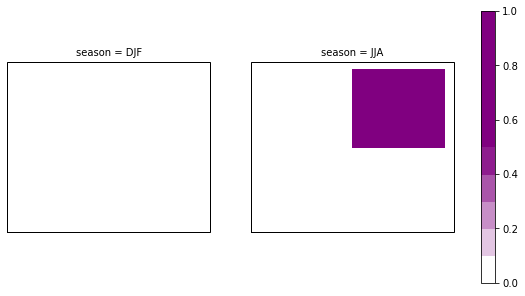

In [37]:
# for just a point or four, a map doesn't make much sense. 
# what would be a good accompanying visualization?
pValToPlot = ksAll.transpose().swaplevel(0,1).transpose()['pvalue'].to_xarray().to_array('season')
plotted = pValToPlot.plot.pcolormesh(transform=ccrs.PlateCarree(),col='season',col_wrap=2,
                                  subplot_kws={'projection':ccrs.LambertCylindrical(200)},
                                         figsize=[10,5],vmin=0,vmax=1,cmap=mycmap)
seasons = ['DJF','JJA']
for i, ax in enumerate(plotted.axes.flat):
    ax.coastlines(linewidth=1.4)

plt.savefig(png)

In [35]:
# write out the text file with the results
ksAll.to_csv(txt)

In [36]:
# demo, read it back in:
ksAllAgain = pd.read_csv(txt,index_col=[0,1],header=[0,1])
ksAllAgain

DJF                 JJA          
                  statistic    pvalue statistic    pvalue
lat       lon                                            
-33.08393 299.250  0.415158  0.000002  0.323544  0.000129
          300.375  0.346154  0.000021  0.234514  0.006874
-31.96244 299.250  0.248370  0.010386  0.256437  0.003600
          300.375  0.268485  0.000334  0.100394  0.589222